Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0314
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2779e-04
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9911e-04
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0459e-04
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9474e-04
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6368e-04
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7361e-04
Epoch 8/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3214e-04
Epoch 9/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5351e-04
Epoch 10/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8641e-04
Epoch 11/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8869e-04
Epoch 12/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5873e-04
Epoch 13/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5024e-04
Epoch 14/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5844e-04
Epoch 15/500
50/50 

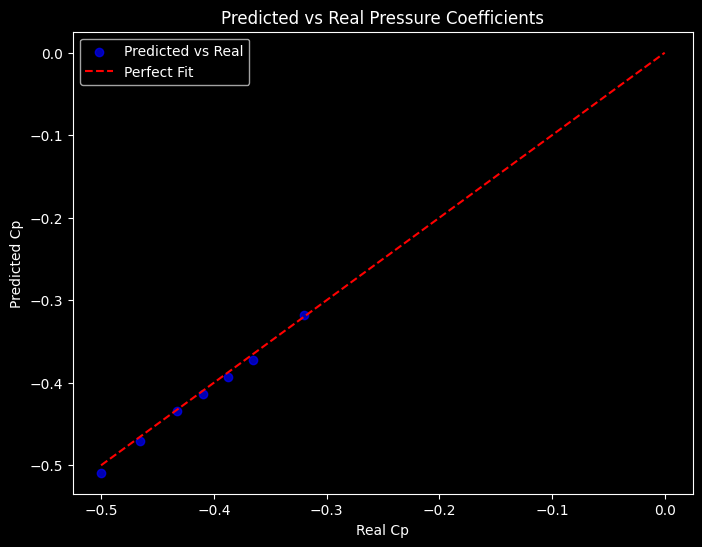

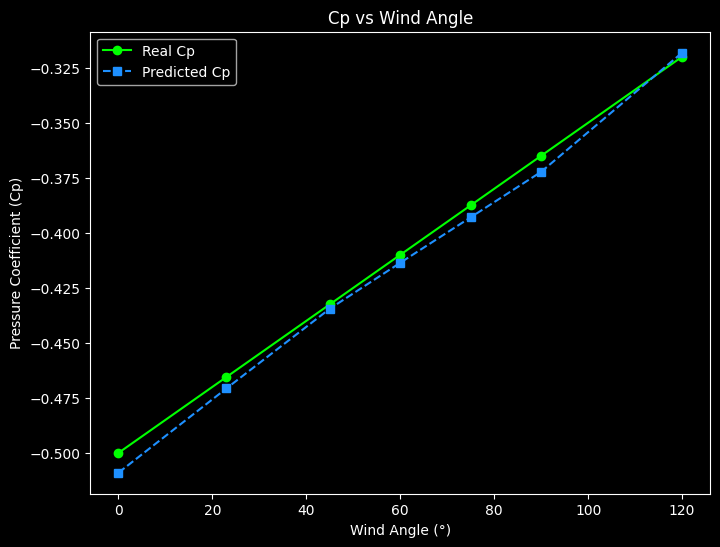

In [33]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Simulated dataset (Replace this with actual data)
np.random.seed(42)
num_samples = 1000

# Features
angles = np.random.uniform(0, 180, num_samples).reshape(-1, 1)  # Wind angles
roof_types = np.random.choice(["o", "a", "b", "c"], num_samples).reshape(-1, 1)  # Roof types

# Real pressure coefficients (Simulated)
Cp_real = -0.5 + 0.0015 * angles + np.random.normal(0, 0.02, size=(num_samples, 1))

# One-hot encode roof types
encoder = OneHotEncoder(sparse_output=False)  # Updated encoder
roof_types_encoded = encoder.fit_transform(roof_types)

# Combine features
X = np.hstack([angles, roof_types_encoded])
y = Cp_real

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the PINN model
inputs = keras.Input(shape=(X_train.shape[1],))
hidden = layers.Dense(64, activation="relu")(inputs)
hidden = layers.Dense(64, activation="relu")(hidden)
outputs = layers.Dense(1)(hidden)  # Predict Cp

model = keras.Model(inputs, outputs)
model.compile(optimizer="adam", loss="mse")

# Train the model
model.fit(X_train, y_train, epochs=500, batch_size=16, verbose=1)

# Predictions
y_pred_train = model.predict(X_train)  # Predictions for training data
y_pred_test = model.predict(X_test)  # Predictions for test data

# Compute R² score for both training and test data
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
print(f"R² Score (Train): {r2_train:.4f}")
print(f"R² Score (Test): {r2_test:.4f}")

# Predictions for visualization
test_angles = np.array([0, 23, 45, 60, 75, 90, 120]).reshape(-1, 1)
test_roof_types = np.array(["o"] * len(test_angles)).reshape(-1, 1)  # Use roof type 'o' for prediction

# One-hot encode test roof types
test_roof_types_encoded = encoder.transform(test_roof_types)
X_vis = np.hstack([test_angles, test_roof_types_encoded])
X_vis = scaler.transform(X_vis)

# Predict Cp for visualization
predicted_Cp = model.predict(X_vis)

# Display predicted Cp values
print("\nPredicted Mean Pressure Coefficients:")
for angle, cp in zip(test_angles.flatten(), predicted_Cp.flatten()):
    print(f"Wind Angle {angle:.1f}°: Predicted Cp = {cp:.4f}")

# Calculate percentage difference
real_Cp_vis = -0.5 + 0.0015 * test_angles  # Approximate real values (replace with actual)
percentage_error = np.abs((predicted_Cp.flatten() - real_Cp_vis.flatten()) / real_Cp_vis.flatten()) * 100
mean_error = np.mean(percentage_error)

print(f"\nMean Percentage Error: {mean_error:.2f}%")

# Plot Predicted vs. Real Cp
plt.style.use("dark_background")
plt.figure(figsize=(8, 6))
plt.scatter(real_Cp_vis, predicted_Cp, color='blue', alpha=0.7, label='Predicted vs Real')
plt.plot([-0.5, 0], [-0.5, 0], linestyle="--", color='red', label="Perfect Fit")
plt.xlabel("Real Cp")
plt.ylabel("Predicted Cp")
plt.title("Predicted vs Real Pressure Coefficients")
plt.legend()
plt.show()

# Plot Cp vs Wind Angle
plt.figure(figsize=(8, 6))
plt.plot(test_angles, real_Cp_vis, marker='o', linestyle='-', color='lime', label="Real Cp")
plt.plot(test_angles, predicted_Cp, marker='s', linestyle='--', color='dodgerblue', label="Predicted Cp")
plt.xlabel("Wind Angle (°)")
plt.ylabel("Pressure Coefficient (Cp)")
plt.title("Cp vs Wind Angle")
plt.legend()
plt.show()
